In [1]:
import altair as alt
import pandas as pd
import numpy as np
# saving data into a file rather than embedding into the chart
alt.data_transformers.enable('json')

#alt.renderers.enable('notebook')
# alt.renderers.enable('jupyterlab')
alt.renderers.enable('default')
from vega_datasets import data
import time
from datetime import date
import datetime
from datetime import datetime
import random

In [2]:
historical = pd.read_csv("historical_initial.csv")
info = pd.read_csv("info_initial.csv")
# info['latitude'] = np.nan
# info['longitude'] = np.nan

In [3]:
zipcodes = data.zipcodes()
indiana = zipcodes[zipcodes.state == "IN"]

In [4]:
info['zip_code'] = info.address.str.split(", IN ").apply(lambda x: x[-1])

In [5]:
info_geo = info.merge(indiana, on = "zip_code")

In [6]:
usmap = data.us_10m()
usmap.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [ ]:
# for index, row in info.iterrows():
#     a = row['address']
#     url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(a) +'?format=json'
    
#     try:
#         response = requests.get(url).json()
#         lat = response[0]["lat"]
#         lon = response[0]["lon"]
#         info.loc[index, "latitude"] = lat
#         info.loc[index, "longitude"] = lon
#     except:
#         pass

In [7]:
historical.head()

,address,Date,Event,Price
0,"100 W Wabash St, Berne, IN 46711",2/12/10,Price change,"$48,000 (-3.8%)"
1,"100 W Wabash St, Berne, IN 46711",4/27/10,Price change,"$45,000 (-6.3%)"
2,"100 W Wabash St, Berne, IN 46711",10/3/10,Price change,"$44,000 (-2.2%)"
3,"100 W Wabash St, Berne, IN 46711",10/7/10,Listing removed,"$44,000 (0%)"
4,"100 W Wabash St, Berne, IN 46711",2/26/19,Listed for sale,0


In [8]:
sold = historical[historical.Event == "Sold"]

In [9]:
sold.Date = sold.Date.apply(lambda x: pd.to_datetime(x, format = "%m/%d/%y"))

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/3256533910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold.Date = sold.Date.apply(lambda x: pd.to_datetime(x, format = "%m/%d/%y"))


In [10]:
from re import sub
from decimal import Decimal

In [11]:
sold['amount']  = sold.Price.str.split(" ").apply(lambda x: sub(r'[^\d.]', '', x[0]))

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/171338973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold['amount']  = sold.Price.str.split(" ").apply(lambda x: sub(r'[^\d.]', '', x[0]))


In [12]:
sold_geo = sold.merge(info_geo, on = "address")

In [13]:
sold_geo['monthyear'] = sold_geo.Date.apply(lambda x: x.to_period("M"))

In [14]:
sold_geo.amount[sold_geo.amount == ""] = np.nan

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/1746239874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_geo.amount[sold_geo.amount == ""] = np.nan


In [15]:
sold_geo = sold_geo[~pd.isnull(sold_geo.amount)]

In [16]:
sold_geo.amount = sold_geo.amount.astype(int)

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/1248385618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_geo.amount = sold_geo.amount.astype(int)


In [17]:
sold_agg = sold_geo.groupby('county', as_index=False).agg({'amount':'mean','beds':'mean','baths':'mean','sqft':'mean'})

In [18]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
states = alt.topo_feature(data.us_10m.url, 'states')

In [19]:
countyfips = pd.read_csv("https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv")
countyfips["county"] = countyfips.name.str.split(" County").apply(lambda x: x[0])
countyfips.rename(columns = {"fips":"id"}, inplace=True)

In [20]:
sold_agg = sold_agg.merge(countyfips[countyfips.state == "IN"])

In [21]:
sold_agg.head()

,county,amount,beds,baths,sqft,id,name,state
0,Adams,118318.278195,2.977444,1.906015,1680.564885,18001,Adams County,IN
1,Allen,110169.458781,3.124253,1.981183,1823.934211,18003,Allen County,IN
2,Bartholomew,120777.212121,2.707071,1.676768,1604.354839,18005,Bartholomew County,IN
3,Clinton,133000.000000,3.000000,2.142857,1745.714286,18023,Clinton County,IN
4,Elkhart,95045.222222,2.444444,1.555556,1420.000000,18039,Elkhart County,IN


In [22]:
alt.Chart(info_geo).mark_circle().encode(
    latitude = "latitude:Q",
    longitude = "longitude:Q",
    color = "beds:N"
).project(
    "albersUsa"
)

alt.Chart(...)

In [23]:
alt.Chart(counties).mark_geoshape().encode(
    color = "beds:Q"
).transform_calculate(
    state_id = "(datum.id / 1000)|0"
    ).transform_filter(
        (alt.datum.state_id)==18).transform_lookup(
            lookup = 'id',
            from_=alt.LookupData(sold_agg,'id',['beds'])
        )

alt.Chart(...)

In [49]:
alt.Chart(counties).mark_geoshape().encode(
    color = "sqft:Q"
).transform_calculate(
    state_id = "(datum.id / 1000)|0"
    ).transform_filter(
        (alt.datum.state_id)==18).transform_lookup(
            lookup = 'id',
            from_=alt.LookupData(sold_agg,'id',['sqft'])
        )

alt.Chart(...)

Redoing scraping for data collection, focused on Hamilton County

In [26]:
from bs4 import BeautifulSoup
import regex as re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import requests

In [5]:
ser = Service('/Users/lelee1/Desktop/D590VIZ/chromedriver')
op = webdriver.ChromeOptions()

In [72]:
county_base = "https://www.zillow.com/browse/homes/in/hamilton-county/"
# hamilton_zips = ['46032', '46037', '46033', '46038', '46062', '46074', '46040', '46069', '46034', '46280', '46031', '46030']
hamilton_zips = ['46037', '46033', '46038', '46062', '46074', '46040', '46069', '46034', '46280', '46031', '46030']
hamilton_counts = [55, 45, 46, 47, 57, 21, 10, 10, 10, 4, 5]
# hamilton_counts = [54, 50, 55, 45, 46, 47, 57, 21, 10, 10, 10, 4, 5]
# hamilton_homes = []
props = ['og:zillow_fb:address','zillow_fb:beds','zillow_fb:baths']
labels = ['address','beds','baths','sqft','link', 'zestimate']

fishers_carmel_zips = [46037,46038,46040,46032,46033]
fishers_carmel_counts = [55,46,21,54,45]

In [28]:
fishers_carmel_homes = []

In [ ]:
# def homedetails(href):
#     return href and re.compile("/homedetails").search(href)

# for i in range(len(hamilton_zips) - 1):
#     num_pages = hamilton_counts[i]
#     zip_interest = hamilton_zips[i]
#     for i in range(num_pages):
#         browser = webdriver.Chrome(service=ser, options=op)
#         url = county_base + zip_interest + '/' + str(i) + '/'
#         time.sleep(random.randint(1,4))
#         browser.get(url)
#         soup = BeautifulSoup(browser.page_source)
#         browser.quit()
#         for a in soup.find_all(href = homedetails):
#             hamilton_homes.append('https://www.zillow.com' + a.get('href'))

In [470]:
def homedetails(href):
    return href and re.compile("/homedetails").search(href)

for i in [41,42,43,44,45,46]:

    url = county_base + str(46038) + '/' + str(i) + '/'
    req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3163.100 Safari/537.36'
    }
    
    with requests.Session() as s: 
        r = s.get(url, headers=req_headers)
        soup = BeautifulSoup(r.content, "html.parser")
    for a in soup.find_all(href = homedetails):
        fishers_carmel_homes.append('https://www.zillow.com' + a.get('href'))

In [32]:
hamilton_df = pd.DataFrame(columns = ['address','beds','baths','sqft','link', 'zestimate', 'lat','lon', 'zip_code','price_sqft'])

In [ ]:
# for url in hamilton_homes:
#     browser = webdriver.Chrome(service=ser, options=op)
#     browser.get(url)
#     time.sleep(random.randint(1,4))
#     soup = BeautifulSoup(browser.page_source)
#     browser.quit()
#     try:
#         for x in soup.find_all('meta', {'property':"og:zillow_fb:address"},'content'):
#             address = x.get('content')
    
#         info = []
#         for p in props:
#             for x in soup.find_all('meta',{'property':p},'content'):
#                 info.append(x.get('content'))
#         info.append(''.join(re.findall('([0-9])',soup.find_all('span',{'data-testid':"bed-bath-beyond"})[0].find_all('span')[6].text)))
#         info.append(url)
#         info_new = {labels[i]:info[i] for i in range(len(labels))}
#         hamilton_df = hamilton_df.append(info_new, ignore_index=True)
#     except:
#         pass
#     # hamilton_homes.remove(url)
# 5157

In [ ]:
for url in fishers_carmel_homes:
    req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3163.100 Safari/537.36'
    }
    
    with requests.Session() as s: 
        r = s.get(url, headers=req_headers)
        soup = BeautifulSoup(r.content, "html.parser")
    # soup = BeautifulSoup(browser.page_source)
    # browser.quit()
    try:
        for x in soup.find_all('meta', {'property':"og:zillow_fb:address"},'content'):
            address = x.get('content')
        zest = soup.find_all('span',{'class':'Text-c11n-8-65-2__sc-aiai24-0 dGfmPL'})[0].get_text('span')
        info = []
        for p in props:
            for x in soup.find_all('meta',{'property':p},'content'):
                info.append(x.get('content'))
        info.append(''.join(re.findall('([0-9])',soup.find_all('span',{'data-testid':"bed-bath-beyond"})[0].find_all('span')[6].text)))
        info.append(url)
        info.append(zest)
        info_new = {labels[i]:info[i] for i in range(len(labels))}
        hamilton_df = hamilton_df.append(info_new, ignore_index=True)
    except:
        pass

In [84]:
import requests
import urllib.parse

39.947311799271
-85.99423139060731


In [635]:
for index, row in hamilton_df[29598:].iterrows():
    urlexp = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(row.address) + '?format=json'

    responseexp = requests.get(urlexp).json()
    try:
        hamilton_df.iloc[index,6] = responseexp[0]["lat"]
        hamilton_df.iloc[index,7] = responseexp[0]["lon"]
    except:
        pass

In [638]:
hamilton_df.to_csv('hamilton-df.csv', index = False)

In [24]:
hamilton_df = pd.read_csv('hamilton-df.csv')

In [25]:
hamilton_df['zip_code'] = hamilton_df.address.str.split(", IN ").apply(lambda x: x[-1])

In [26]:
hamilton_df['amount']  = hamilton_df.zestimate.apply(lambda x: sub(r'[^\d.]', '', str(x)))

In [27]:
hamilton_df.amount[hamilton_df.amount == ""] = np.nan
hamilton_df.sqft[hamilton_df.sqft == ""] = np.nan

hamilton_df.amount[hamilton_df.amount == 0] = np.nan
hamilton_df.sqft[hamilton_df.sqft == 0] = np.nan


hamilton_df.beds[hamilton_df.beds == 0] = np.nan
hamilton_df.baths[hamilton_df.baths == 0] = np.nan

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/508994145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_df.amount[hamilton_df.amount == ""] = np.nan
/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/508994145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_df.sqft[hamilton_df.sqft == ""] = np.nan
/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/508994145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [28]:
hamilton_df['price_sqft'] = hamilton_df.amount.astype(float) / hamilton_df.sqft.astype(float)

In [29]:
hamilton_geo = hamilton_df[(~pd.isnull(hamilton_df.lat)) & (~pd.isnull(hamilton_df.lon))]

In [30]:
alt.Chart(hamilton_geo).mark_circle(size = 3, opacity=0.5).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "amount:Q"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [31]:
hamilton_geo.lat = hamilton_geo.lat.astype(float)
hamilton_geo.lon = hamilton_geo.lon.astype(float)

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/567423631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_geo.lat = hamilton_geo.lat.astype(float)
/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/567423631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_geo.lon = hamilton_geo.lon.astype(float)


array([[<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lon'}>]], dtype=object)

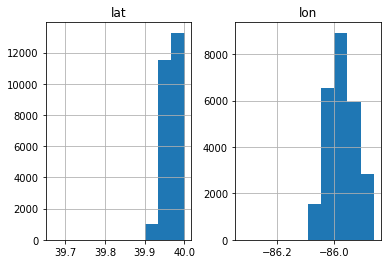

In [32]:
hamilton_geo[['lat','lon']].hist()

In [36]:
lat = alt.Chart(hamilton_geo).mark_bar().encode(
    x = alt.X('lat:Q', bin= True),
    y = 'count()'
)

lon = alt.Chart(hamilton_geo).mark_bar().encode(
    x = alt.X('lon:Q', bin= True),
    y = 'count()'
)

lat | lon

alt.HConcatChart(...)

In [38]:
lat = alt.Chart(hamilton_geo[(hamilton_geo.lat >= 39.9)]).mark_bar().encode(
    x = alt.X('lat:Q', bin= True),
    y = 'count()'
)

lon = alt.Chart(hamilton_geo[(hamilton_geo.lat >= 39.9)]).mark_bar().encode(
    x = alt.X('lon:Q', bin= True),
    y = 'count()'
)

lat | lon

alt.HConcatChart(...)

In [39]:
hamilton = hamilton_geo[(hamilton_geo.lat >= 39.9)]

In [40]:
alt.Chart(hamilton).mark_circle(size = 3, opacity=0.5).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "beds:Q"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [41]:
alt.Chart(hamilton).mark_circle(size = 3, opacity=0.5).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "amount:Q"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [42]:
hamilton_nan = hamilton.dropna()

In [43]:
hamilton_nan.amount = hamilton_nan.amount.astype(int)

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/2381223391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_nan.amount = hamilton_nan.amount.astype(int)


In [44]:
alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    x='beds:Q'
)

alt.Chart(...)

In [45]:
alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    x='baths:Q'
)

alt.Chart(...)

In [46]:
alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    x='sqft:Q'
)

alt.Chart(...)

In [822]:
alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
   x='amount:Q'
)

alt.Chart(...)

In [823]:
alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    x='price_sqft:Q'
)

alt.Chart(...)

In [835]:
nolog = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y='sqft:Q'
)

logged = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y=alt.X('sqft:Q', scale = alt.Scale(type = "log"))
)

nolog | logged

alt.HConcatChart(...)

In [47]:
nolog = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y='amount:Q'
)

logged = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y=alt.X('amount:Q', scale = alt.Scale(type = "log"))
)

nolog | logged

alt.HConcatChart(...)

In [48]:
nolog = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y='price_sqft:Q'
)

logged = alt.Chart(hamilton_nan).mark_boxplot(extent='min-max').encode(
    y=alt.X('price_sqft:Q', scale = alt.Scale(type = "log"))
)

nolog

alt.Chart(...)

In [824]:
alt.Chart(hamilton_nan).mark_circle(size = 3).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "amount:Q"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [776]:
alt.Chart(hamilton_nan).mark_circle(size = 3).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "sqft:Q"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [783]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = "zip_code:N"
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [50]:
hamilton_nan['price_cat'] = pd.cut(hamilton_nan.amount.astype(int),
 [0,100000,200000,250000,300000,350000,400000,450000,500000,550000,600000,20000000],
  labels = ['$0',
  '$0 - $100,000',
  '$100,000 - $200000',
  '$200,000 - $250,000',
  '$250,000 - $300,000',
  '$300,000 - $350,000',
  '$350,000 - $400,000',
  '$400,000 - $450,000',
  '$450,000 - $500,000',
  '$500,000 - $550,000',
  '$600,000+'])

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_24123/599921502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_nan['price_cat'] = pd.cut(hamilton_nan.amount.astype(int),


In [863]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("amount:Q", scale = alt.Scale(type="log"))
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [51]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("price_cat:O")
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [883]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("price_cat:O"),
    tooltip = [alt.Tooltip('address'),
    alt.Tooltip('beds'),
    alt.Tooltip('baths'),
    alt.Tooltip('sqft'),
    alt.Tooltip('zestimate')]
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)


alt.Chart(...)

In [902]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("price_cat:O", scale = alt.Scale(type="log", scheme = "viridis")),
    tooltip = [alt.Tooltip('address'),
    alt.Tooltip('beds'),
    alt.Tooltip('baths'),
    alt.Tooltip('sqft'),
    alt.Tooltip('zestimate')]
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

In [900]:
hamilton_nan['price_sqft_cat'] = pd.cut(hamilton_nan.price_sqft.astype(float),
 [0,50,100,125,150,175,200,225,2000],
  labels = [
  '$0 - $50/sqft',
  '$50 - $100/sqft',
  '$100- $125/sqft',
  '$125 - $150/sqft',
  '$150 - $175/sqft',
  '$175 - $200/sqft',
  '$200 - $225/sqft',
  '$225+/sqft'])

/var/folders/lh/tw7lgns53bsgp8s5xtzzd4rw0000gp/T/ipykernel_7689/3519133494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamilton_nan['price_sqft_cat'] = pd.cut(hamilton_nan.price_sqft.astype(float),


In [901]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("price_sqft_cat:O", scale = alt.Scale(type="log", scheme = "viridis"))
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)

# FINAL VISUALIZATION

In [52]:
alt.Chart(hamilton_nan).mark_circle(size = 7).encode(
    latitude = "lat:Q",
    longitude = "lon:Q",
    color = alt.Color("price_cat:O", scale = alt.Scale(type="log", scheme = "viridis")),
    tooltip = [alt.Tooltip('address'),
    alt.Tooltip('beds'),
    alt.Tooltip('baths'),
    alt.Tooltip('sqft'),
    alt.Tooltip('zestimate')]
).project(
    "albersUsa"
).properties(
    width=700,
    height=400,
)

alt.Chart(...)